In [1]:
"""
Created on Sun Mar 17 20:53:24 2019

@author: vivek
"""
# Call data manipulation libraries
import pandas as pd
import numpy as np

#Feature creation libraries
from sklearn.random_projection import SparseRandomProjection as sr  # Projection features
from sklearn.cluster import KMeans                    # Cluster features
from sklearn.preprocessing import PolynomialFeatures  # Interaction features

#For feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif  # Selection criteria

#Data processing
#caling data in various manner
from sklearn.preprocessing import StandardScaler, MinMaxScaler, scale
#Transform categorical (integer) to dummy
from sklearn.preprocessing import OneHotEncoder

#Splitting data
from sklearn.model_selection import train_test_split

#Decision tree modeling
from sklearn.tree import  DecisionTreeClassifier as dt

# RandomForest modeling
from sklearn.ensemble import RandomForestClassifier as rf

# Plotting libraries to plot feature importance
import matplotlib.pyplot as plt
import seaborn as sns

# Misc
import os, time, gc
print(os.listdir("../input"))


['heart.csv']


In [2]:
# Set working directory to read file
os.chdir("../input")

# Read the file provided
heartdf=pd.read_csv("heart.csv")

In [3]:
# Have a look at the data
heartdf.shape
heartdf.dtypes # All afeatures are integers
heartdf.head(3)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1


In [4]:
#Seperate the predictors and target columns

x=heartdf.drop(columns = ['target'])#Predictors
x.shape  #(303, 13)
y=heartdf['target'] #target column
y.shape  #(303,)

(303,)

In [5]:
x_train,x_test,y_train,y_test=train_test_split(     x,    # Predictors
                                                    y,                   # Target
                                                    test_size = 0.3      # split-ratio
                                                    )

x_train.shape #(212, 13)
x_test.shape #(91, 13)
y_train.shape #(212,)
y_test.shape  #(91,)

(91,)

In [6]:
#check if all the columns are zeroes in any row
x = np.sum(x_train, axis = 1)
v = x.index[x == 0]             # Get index of the row which meets a condition
v

# Drop the rows from test data if v is not empty
x_test.drop(v, axis = 0, inplace = True)
x_test.shape  #no drop of rows           

(91, 13)

In [7]:
# Check if there are Missing values? None
x_train.isnull().sum().sum()  # 0
x_test.isnull().sum().sum()   # 0

0

In [8]:
############################ BB. Feature Engineering #########################
############################ Using Statistical Numbers #####################

In [9]:
#  Assume that value of '0' in a cell implies missing feature
#     Transform train and test dataframes
#     replacing '0' with NaN
#     Use pd.replace()

#converting to nan for the quick calculations of mean,median,variance...
tmp_train = x_train.replace(0, np.nan)
tmp_test = x_test.replace(0,np.nan)


#  Check if 0 has been replaced by NaN
tmp_train.head(1)
tmp_test.head(1)

tmp_train.notna().head(1)
x_train["count_not0"] = tmp_train.notna().sum(axis = 1)
x_test['count_not0'] = tmp_test.notna().sum(axis = 1)
x_test['count_not0'].head()

151     8
85      8
295    10
115     8
11      9
Name: count_not0, dtype: int64

In [10]:
# Similary create other statistical features
# Pandas has a number of statistical functions like  "var", "median", "mean", "std", "max", "min"
# Row sums of features 1:13. More successful when data is binary.
feat = [ "var", "median", "mean", "std", "max", "min","sum"]
for i in feat:
    x_train[i] = tmp_train.aggregate(i,  axis =1)
    x_test[i]  = tmp_test.aggregate(i,axis = 1)

x_train.shape # (212, 21)
x_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,count_not0,var,median,mean,std,max,min,sum
271,61,1,3,134,234,0,1,145,0,2.6,1,2,2,11,6620.298182,2.60,53.327273,81.365215,234.0,1.0,586.6
267,49,1,2,118,149,0,0,126,0,0.8,2,3,2,10,3769.095111,2.50,45.280000,61.392957,149.0,0.8,452.8
150,66,1,0,160,228,0,0,138,0,2.3,2,0,1,8,8035.704107,34.15,74.787500,89.642089,228.0,1.0,598.3
143,67,0,0,106,223,0,1,142,0,0.3,2,2,2,9,6573.996111,2.00,60.588889,81.080183,223.0,0.3,545.3
275,52,1,0,125,212,0,1,168,0,1.0,2,2,3,10,6596.455556,2.50,56.700000,81.218567,212.0,1.0,567.0


In [11]:
############################################################################
################ Feature creation Using Random Projections ##################
#  Random projection is a fast dimensionality reduction feature
#     Also used to look at the structure of data

In [12]:
#  Generate features using random projections
#     First stack train and test data, one upon another
tmp = pd.concat([x_train,x_test],
                axis = 0,            # Stack one upon another (rbind)
                ignore_index = True
                )
tmp.shape

(303, 21)

In [13]:
#  Let us create 5 random projections/columns
#     This decision, at present, is arbitrary
NUM_OF_COM = 5

# Transform tmp t0 numpy array
#      Henceforth we will work with array only
tmp = tmp.values
tmp.shape    # (303, 21)

(303, 21)

In [14]:
#  Create an instance of class
rp_instance = sr(n_components = NUM_OF_COM)

In [15]:
# fit and transform the (original) dataset
# Random Projections with desired number of components are returned
rp = rp_instance.fit_transform(tmp[:, :13])
rp.shape

(303, 5)

In [16]:
# Create some column names for these columns
#      We will use them at the end of this code
rp_col_names = ["r" + str(i) for i in range(5)]
rp_col_names

['r0', 'r1', 'r2', 'r3', 'r4']

In [17]:
###############################################################################
############################ Feature creation using kmeans ####################
######################Can be skipped without loss of continuity################


In [18]:
# Before clustering, scale data
#  Create a StandardScaler instance
se = StandardScaler()
# fit() and transform() in one step
tmp = se.fit_transform(tmp)

In [19]:
#     No of centroids is no of classes in the 'target'
centers = heartdf['target'].nunique()    # 2 unique classes
centers               # 2

2

In [20]:
# Begin clustering
#  First create object to perform clustering
kmeans = KMeans(n_clusters=centers, # How many
                n_jobs = 2)         # Parallel jobs for n_init

In [21]:
# Next train the model on the original data only
kmeans.fit(tmp[:, : 13])

#  Get clusterlabel for each row (data-point)
kmeans.labels_
kmeans.labels_.size   # 303

303

In [22]:
# If Cluster labels are categorical convert them to dummy
# Create an instance of OneHotEncoder class
ohe = OneHotEncoder(sparse = False)

In [23]:
#  Use ohe to learn data
#      ohe.fit(kmeans.labels_)
ohe.fit(kmeans.labels_.reshape(-1,1))     # reshape(-1,1) recommended by fit()
                                          # '-1' is a placeholder for actual

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


OneHotEncoder(categorical_features=None, categories=None,
       dtype=<class 'numpy.float64'>, handle_unknown='error',
       n_values=None, sparse=False)

In [24]:
# Transform data now
dummy_clusterlabels = ohe.transform(kmeans.labels_.reshape(-1,1))#Reshape is used because onehot cannot recognise if it is in array form like (1,2,3,4,,,,)
dummy_clusterlabels
dummy_clusterlabels.shape    # 303 X 2 (as many as there are classes)

(303, 2)

In [25]:
#  We will use the following as names of new nine columns
#      We need them at the end of this code

k_means_names = ["k" + str(i) for i in range(2)]
k_means_names

['k0', 'k1']

In [26]:
############################ Interaction features #######################
# Will require lots of memory if we take large number of features
#     Best strategy is to consider only impt features

degree = 2
poly = PolynomialFeatures(degree,                 # Degree 2
                          interaction_only=True,  # Avoid e.g. square(a)#not includes f1square and f2square
                          include_bias = False    # No constant term
                          )

In [27]:
#  Consider only first 8 features to save memory
#      fit and transform
df =  poly.fit_transform(tmp[:, : 8])

df.shape     # 303 X 36

(303, 36)

In [28]:
# Generate some names for these 36 columns
poly_names = [ "poly" + str(i)  for i in range(36)]
poly_names

['poly0',
 'poly1',
 'poly2',
 'poly3',
 'poly4',
 'poly5',
 'poly6',
 'poly7',
 'poly8',
 'poly9',
 'poly10',
 'poly11',
 'poly12',
 'poly13',
 'poly14',
 'poly15',
 'poly16',
 'poly17',
 'poly18',
 'poly19',
 'poly20',
 'poly21',
 'poly22',
 'poly23',
 'poly24',
 'poly25',
 'poly26',
 'poly27',
 'poly28',
 'poly29',
 'poly30',
 'poly31',
 'poly32',
 'poly33',
 'poly34',
 'poly35']

In [29]:
################# concatenate all features now ##############################

# Append now all generated features together
# Append random projections, kmeans and polynomial features to tmp array

tmp.shape          # 303 X 21

(303, 21)

In [30]:
# If variable, 'dummy_clusterlabels', exists, stack kmeans generated
# columns also else not. 'vars()'' is an inbuilt function in python.All python variables are contained in vars().

if ('dummy_clusterlabels' in vars()):               #
    tmp = np.hstack([tmp,rp,dummy_clusterlabels, df])
else:
    tmp = np.hstack([tmp,rp, df])       # No kmeans      <==


tmp.shape          # 303 X 64  

(303, 64)

In [31]:
#  Separate train and test
X = tmp[: x_train.shape[0], : ]
X.shape                             # 212 X 64 if no kmeans: (61878, 126)

test = tmp[x_train.shape[0] :, : ]
test.shape                         # 91 X 64; if no kmeans: (144367, 126)

(91, 64)

In [32]:
################## Model building #####################

y_train.shape
#  Split data into training and validation dataset
X_train, X_test, y_train, y_test = train_test_split(
                                                    X,
                                                    y_train,
                                                    test_size = 0.3)
X_train.shape    # 148 X 64
X_test.shape     # 64 X 64;

(64, 64)

In [33]:
# Decision tree classification
#  Create an instance of class
clf = dt(min_samples_split = 5,
         min_samples_leaf= 4
        )

In [34]:
#  Fit/train the object on training data
#      Build model
clf = clf.fit(X_train, y_train)
            
# Use model to make predictions
classes = clf.predict(X_test)

#  Check accuracy
(classes == y_test).sum()/y_test.size

0.78125

In [35]:
#  Get feature importance
clf.feature_importances_        # Column-wise feature importance
clf.feature_importances_.size   # 64

# To our list of column names, append all other col names
#      generated by random projection, kmeans (onehotencoding)
#      and polynomial features
#      But first check if kmeans was used to generate features
colNames = x_train.columns.values
len(colNames)
if ('dummy_clusterlabels' in vars()):       # If dummy_clusterlabels labels are defined
    colNames = list(colNames) + rp_col_names+ k_means_names + poly_names
else:
    colNames = colNames = list(colNames) + rp_col_names +  poly_names      # No kmeans      <==


In [36]:
# Create a dataframe of feature importance and corresponding
#      column names. Sort dataframe by importance of feature
feat_imp = pd.DataFrame({
                   "importance": clf.feature_importances_ ,
                   "featureNames" : colNames
                  }
                 ).sort_values(by = "importance", ascending=False)



In [37]:
feat_imp.shape                   # 135 X 2 ; without kmeans: (126,2)
feat_imp.head(30)

,importance,featureNames
26,0.497597,k0
37,0.102300,poly9
1,0.087101,sex
54,0.070102,poly26
39,0.066655,poly11
49,0.059546,poly21
60,0.042249,poly32
56,0.026639,poly28
4,0.022943,chol
2,0.017253,cp


[Text(0,0,'k0'),
 Text(0,0,'poly9'),
 Text(0,0,'sex'),
 Text(0,0,'poly26'),
 Text(0,0,'poly11'),
 Text(0,0,'poly21'),
 Text(0,0,'poly32'),
 Text(0,0,'poly28'),
 Text(0,0,'chol'),
 Text(0,0,'cp'),
 Text(0,0,'oldpeak'),
 Text(0,0,'age'),
 Text(0,0,'poly14'),
 Text(0,0,'poly16'),
 Text(0,0,'poly15'),
 Text(0,0,'poly12'),
 Text(0,0,'poly13'),
 Text(0,0,'poly18'),
 Text(0,0,'poly10'),
 Text(0,0,'poly17')]

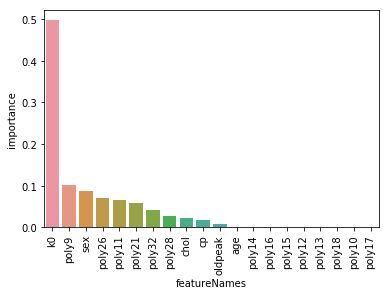

In [38]:
# Plot feature importance for first 20 features
g = sns.barplot(x = feat_imp.iloc[  : 20 ,  1] , y = feat_imp.iloc[ : 20, 0])
g.set_xticklabels(g.get_xticklabels(),rotation=90)

#In below graph we can clearly observe that cluster K0 plays a mojor role in Decision tree classification

In [39]:
# Random Forest classification
#  Instantiate RandomForest classifier
clf = rf(n_estimators=50)

#  Fit/train the object on training data
#      Build model
clf = clf.fit(X_train, y_train)

#  Use model to make predictions
classes = clf.predict(X_test)
# Check accuracy
(classes == y_test).sum()/y_test.size  

0.8125

In [40]:
#  Get feature importance
clf.feature_importances_        # Column-wise feature importance
clf.feature_importances_.size   # 64


# To our list of column names, append all other col names
#      generated by random projection, kmeans (onehotencoding)
#      and polynomial features
#      But first check if kmeans was used to generate features
colNames = x_train.columns.values
len(colNames)
if ('dummy_clusterlabels' in vars()):       # If dummy_clusterlabels labels are defined
    colNames = list(colNames) + rp_col_names+ k_means_names + poly_names
else:
    colNames = colNames = list(colNames) + rp_col_names +  poly_names      # No kmeans      <==

In [41]:
feat_imp = pd.DataFrame({
                   "importance": clf.feature_importances_ ,
                   "featureNames" : colNames
                  }
                 ).sort_values(by = "importance", ascending=False)


feat_imp.shape                   # 135 X 2 ; without kmeans: (126,2)
feat_imp.head(30)

,importance,featureNames
26,0.083208,k0
27,0.071599,k1
10,0.035007,slope
11,0.034883,ca
2,0.034567,cp
7,0.029879,thalach
30,0.029444,poly2
12,0.028064,thal
42,0.026283,poly14
35,0.024644,poly7


[Text(0,0,'k0'),
 Text(0,0,'k1'),
 Text(0,0,'slope'),
 Text(0,0,'ca'),
 Text(0,0,'cp'),
 Text(0,0,'thalach'),
 Text(0,0,'poly2'),
 Text(0,0,'thal'),
 Text(0,0,'poly14'),
 Text(0,0,'poly7'),
 Text(0,0,'poly24'),
 Text(0,0,'poly9'),
 Text(0,0,'age'),
 Text(0,0,'poly26'),
 Text(0,0,'oldpeak'),
 Text(0,0,'r0'),
 Text(0,0,'poly25'),
 Text(0,0,'poly34'),
 Text(0,0,'median'),
 Text(0,0,'mean')]

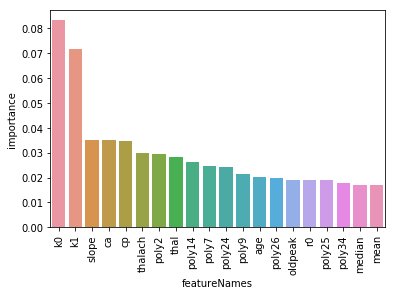

In [42]:
# Plot feature importance for first 20 features
g = sns.barplot(x = feat_imp.iloc[  : 20 ,  1] , y = feat_imp.iloc[ : 20, 0])
g.set_xticklabels(g.get_xticklabels(),rotation=90)